To work that line, you need to implement requirementsxg.txt.


To get open data, you need to use: https://github.com/ML-KULeuven/soccer_xg/blob/master/notebooks/1-load-and-convert-wyscout-data.ipynb

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from soccer_xg.api import DataApi
import soccer_xg.xg as xg
from soccer_xg.utils import sample_temporal

In [2]:
# dataset
dir_data = "../cse-552-project/data"
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']

In [3]:
api = DataApi([f"{dir_data}/{provider}/spadl-{provider}-{l}-{s}.h5" 
        for (l,s) in itertools.product(leagues, seasons)])

In [4]:
model = xg.XGModel()

In [5]:
model.train(api, training_seasons=[('ESP', '1718'), ('ITA', '1718'), ('FRA', '1718'), ('GER', '1718')])

Generating labels: 100%|██████████| 1446/1446 [00:35<00:00, 40.27it/s]


Generating features: 100%|██████████| 380/380 [00:06<00:00, 54.55it/s]
c:\Users\Megad\AppData\Local\Programs\Python\Python38\lib\site-packages\soccer_xg\metrics.py:132: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (y_pred[y_true])[:, np.newaxis]
c:\Users\Megad\AppData\Local\Programs\Python\Python38\lib\site-packages\soccer_xg\metrics.py:135: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred[:, np.newaxis]
No handles with labels found to put in legend.
c:\Users\Megad\AppData\Local\Programs\Python\Python38\lib\site-packages\soccer_xg\metrics.py:132: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before in

{'max_dev': 31.456538040257612,
 'residual_area': 825.5885675697403,
 'roc': 0.7849296717072628,
 'brier': 0.08443180115335167,
 'ece': 0.006017457552643997,
 'ace': 0.009756428433315346,
 'fig': <Figure size 720x360 with 3 Axes>}

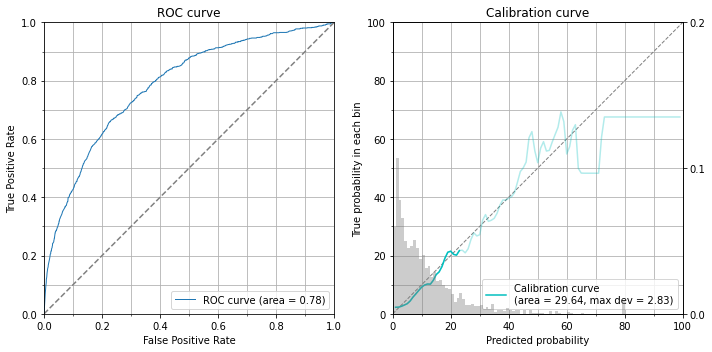

In [6]:
model.validate(api, validation_seasons=[('ENG', '1718')])

In [7]:
games_eng_1718 = api.games[api.games.competition_id == 'ENG']
xg_eng_1718 = model.estimate(api, game_ids=games_eng_1718.index)

Generating features: 100%|██████████| 380/380 [00:08<00:00, 44.36it/s]


In [8]:
(xg_eng_1718
 # find player id for each shot
 .join(api.actions.set_index(['game_id', 'action_id']), how="left")
 # sum xG values for each player
 .groupby('player_id')[['xG']].sum()
 # find player name
 .join(api.players[['short_name']], how="left")
 # get top 10
 .sort_values(by='xG', ascending=False).head(n=10)
 # clean up the list
 .set_index('short_name', drop=True)
)

,xG
short_name,
H. Kane,25.602063
Mohamed Salah,20.454245
S. Agüero,16.132268
R. Lukaku,15.323164
R. Sterling,14.602282
J. Vardy,14.345721
A. Lacazette,12.229020
Gabriel Jesus,11.982988
G. Murray,11.854738


In [9]:
# 1️⃣ xG değerlerini asıl actions tablosuna ekle
events_with_xg = api.actions.set_index(['game_id', 'action_id']).join(
    xg_eng_1718, how='left'
)

# 2️⃣ xG’si olmayanlar için (örneğin şut olmayan eventler) 0 koymak istersen
events_with_xg['xG'] = events_with_xg['xG'].fillna(0)

# veya tümünü görmek için
events_with_xg


period_id  time_seconds  team_id  player_id  start_x  \
game_id   action_id                                                         
2499719.0 0                1.0      2.758649   1609.0    25413.0    51.45   
          1                1.0      4.946850   1609.0   370224.0    32.55   
          2                1.0      6.542188   1609.0     3319.0    53.55   
          3                1.0      8.143395   1609.0   120339.0    36.75   
          4                1.0     10.302366   1609.0   167145.0    43.05   
...                        ...           ...      ...        ...      ...   
2517044.0 1150             2.0   2817.761761   2463.0    94831.0    17.85   
          1151             2.0   2818.280436   2451.0    14917.0    17.85   
          1152             2.0   2823.180681   2451.0    14804.0    23.10   
          1153             2.0   2828.080925   2451.0    14804.0     0.00   
          1154             2.0   2829.509819   2463.0    15317.0     5.25   

                     start_y  end_x  end_y  bodypart_id  type_id  result_id  \
game_id   action_id                                                           
2499719.0 0            34.68  32.55  14.96            0        0          1   
          1            14.96  53.55  17.00            0        0          1   
          2            17.00  36.75  19.72            1        0          1   
          3            19.72  43.05   3.40            1        0          1   
          4             3.40  75.60   8.16            0        0          1   
...                      ...    ...    ...          ...      ...        ...   
2517044.0 1150         31.28  17.85  31.28            0       11          0   
          1151         31.96  23.10  27.20            0       10          1   
          1152         27.20   0.00   3.40            0       21          1   
          1153          3.40   5.25   4.76            0        0          0   
          1154          4.76   0.00  68.00            0       10          1   

                                                               db_path   xG  
game_id   action_id                                                          
2499719.0 0          ../cse-552-project/data/wyscout_opensource/spa...  0.0  
          1          ../cse-552-project/data/wyscout_opensource/spa...  0.0  
          2          ../cse-552-project/data/wyscout_opensource/spa...  0.0  
          3          ../cse-552-project/data/wyscout_opensource/spa...  0.0  
          4          ../cse-552-project/data/wyscout_opensource/spa...  0.0  
...                                                                ...  ...  
2517044.0 1150       ../cse-552-project/data/wyscout_opensource/spa...  0.0  
          1151       ../cse-552-project/data/wyscout_opensource/spa...  0.0  
          1152       ../cse-552-project/data/wyscout_opensource/spa...  0.0  
          1153       ../cse-552-project/data/wyscout_opensource/spa...  0.0  
          1154       ../cse-552-project/data/wyscout_opensource/spa...  0.0  

[2321480 rows x 13 columns]

In [10]:
events_with_xg.to_csv("../cse-552-project/data/events_with_xg.csv", encoding="utf-8")
